In [5]:
import torch
from torch.utils.data import DataLoader, Dataset, Subset
import numpy as np
import clip
from PIL import Image
import matplotlib.pyplot as plt
import umap
from collections import defaultdict

device = "mps" if torch.mps.is_available() else "cpu"
print("Using device:", device)

Using device: mps


In [6]:
def load_stl10_images(path, n_images):
    with open(path, "rb") as f:
        data = np.fromfile(f, dtype=np.uint8)
        data = data.reshape(n_images, 3, 96, 96)
        data = np.transpose(data, (0, 2, 3, 1))
    return data

def load_stl10_labels(path, n_images):
    with open(path, "rb") as f:
        labels = np.fromfile(f, dtype=np.uint8)
    return labels

class STL10Dataset(Dataset):
    def __init__(self, images, labels, transform):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.fromarray(self.images[idx].astype(np.uint8))
        label = int(self.labels[idx]) - 1
        img = self.transform(img)
        return img, label

if __name__ == "__main__":
    # Load data
    n_train, n_test = 5000, 8000
    X_train = load_stl10_images("data/stl10_binary/train_X.bin", n_train)
    y_train = load_stl10_labels("data/stl10_binary/train_y.bin", n_train)
    X_test  = load_stl10_images("data/stl10_binary/test_X.bin", n_test)
    y_test  = load_stl10_labels("data/stl10_binary/test_y.bin", n_test)

    # Load CLIP
    model, preprocess = clip.load("ViT-B/32", device=device)

    # Datasets
    train_dataset = STL10Dataset(X_train, y_train, transform=preprocess)
    test_dataset  = STL10Dataset(X_test, y_test, transform=preprocess)

    class_indices = defaultdict(list)
    for i, (_, lbl) in enumerate(train_dataset):
        if len(class_indices[lbl]) < 10:  # 10 samples per class
            class_indices[lbl].append(i)

    balanced_indices = [i for inds in class_indices.values() for i in inds]
    subset = Subset(train_dataset, balanced_indices)
    loader = DataLoader(subset, batch_size=32, shuffle=False)

    # Class names
    class_names = [
        "airplane", "bird", "car", "cat", "deer",
        "dog", "horse", "monkey", "ship", "truck"
    ]

    # Encode class names with CLIP’s text encoder
    with torch.no_grad():
        text_tokens = clip.tokenize([f"a photo of a {c}" for c in class_names]).to(device)
        text_features = model.encode_text(text_tokens)
        text_features /= text_features.norm(dim=-1, keepdim=True)  # normalize

    # Encode images
    image_features, labels = [], []
    with torch.no_grad():
        for images, lbls in loader:
            images = images.to(device)
            feats = model.encode_image(images)
            feats /= feats.norm(dim=-1, keepdim=True)  # normalize
            image_features.append(feats.cpu())
            labels.extend(lbls.numpy())

    image_features = torch.cat(image_features).numpy()
    labels = torch.tensor(labels)
    text_features = text_features.cpu().numpy()

In [7]:

# Combine both embeddings (images + text) for joint projection
all_embeddings = np.vstack([image_features, text_features])
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric="cosine", random_state=42)
proj = reducer.fit_transform(all_embeddings)

# Split back
image_proj = proj[:len(image_features)]
text_proj = proj[len(image_features):]

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


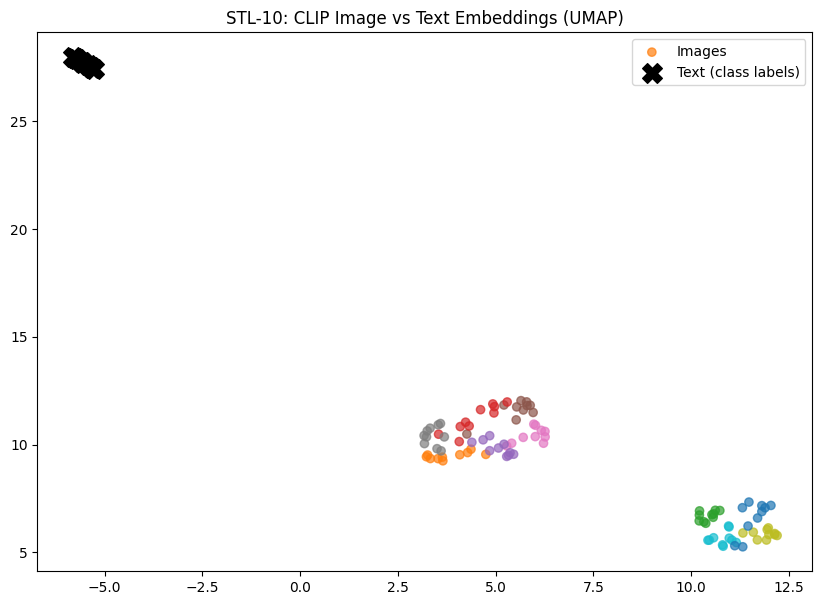

In [8]:
plt.figure(figsize=(10, 7))

# Plot images
scatter = plt.scatter(image_proj[:, 0], image_proj[:, 1], 
                      c=labels, cmap="tab10", alpha=0.7, label="Images")

# Plot text embeddings (class names)
plt.scatter(text_proj[:, 0], text_proj[:, 1], 
            c="black", marker="X", s=200, label="Text (class labels)")

plt.legend(*scatter.legend_elements(), title="Classes")
plt.legend()
plt.title("STL-10: CLIP Image vs Text Embeddings (UMAP)")
plt.show()